In [16]:
import numpy as np
from scipy import *

import sys
sys.path.append('../')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from xppcall import xpprun
import networkx as nx

import conley_functions as cf

import subprocess

time=1000 #simulation time

####Set up network weights
# W=np.array([[0., 1., 0., 1.], [3., 0., -2., .6], [0., -1., 0., 1.], [3., 0., -4., 0.]])/4.
# W=np.array([[0., 1., 0., 1.], [3., 0., -2., .5], [0., -1., 0., 1.], [3., 0., -4., 0.]])/4.

W = 2*np.array([[0., -1., -1.], [-1., 0., -.1], [-1., -1., 0.]])
N = W.shape[0]

In [2]:
#make file to simulate Wilson-Cowan network with XPP
eqstring = ''
wi = 0
for i in range(1,W.shape[0]+1):
    eqstring+='x'+str(i)+"'=-x"+str(i)+"+f(a*x"+str(i)+'-b*y'+str(i)+'+p+'
    for j in range(1,W.shape[1]+1):
        if i!=j:
            eqstring+='w'+str(wi)+"*x"+str(j)+'+'
        wi+=1
    eqstring=eqstring[:-1]+')\n'
    
wi = 0
for i in range(1,W.shape[0]+1):
    eqstring+='y'+str(i)+"'=(-y"+str(i)+"+f(c*x"+str(i)+'-d*y'+str(i)+'+q+'
    for j in range(1,W.shape[1]+1):
        if i!=j:
            eqstring+='w'+str(wi)+"*y"+str(j)+'+'
        wi+=1
    eqstring=eqstring[:-1]+'))/tau\n'

weighstring = 'p '
wi=0
for i in range(0,W.shape[0]):
    for j in range(0,W.shape[1]):
        weighstring+='w'+str(wi)+'='+str(round(W[i,j], 2))+','
        wi+=1
        
initstring = 'init '
inits = np.random.rand(2*N)
for i in range(W.shape[0]):
        initstring+='x'+str(int(i+1))+'='+str(inits[i])+','
        
for i in range(W.shape[0]):
        initstring+='y'+str(i+1)+'='+str(inits[N+i])+','

wcstring = "# the wilson-cowan equations\n"
wcstring += "f(u)=1/(1+exp(-u))\n"
wcstring += eqstring[:-1] + "\n"
wcstring += weighstring[:-1] + "\n"
wcstring += "par a=16,b=12,c=16,d=5,p=-1,q=-4,tau=1\n"
wcstring += initstring[:-1] + "\n"
wcstring += '@ xp=x1,yp=y1,xlo=-.125,ylo=-.125,xhi=1,yhi=1\n'
wcstring += "done"
with open('wc_p.ode', 'w') as f:
    f.writelines(wcstring)

In [3]:
#Simulate network with two initial values
time=2000
inits = [0.4, 0.15, 0.91, 0.58, 0.84, 0.29]
inits_dict={}
for i,init in enumerate(inits[:int(N)]):
    inits_dict['x'+str(i+1)]=init
for i,init in enumerate(inits[int(N):]):
    inits_dict['y'+str(i+1)]=init
npa, vn = xpprun('wc_p.ode',inits=inits_dict, parameters={'total':time}, clean_after=True)

inits = [0.75, 0.11, 0.04, 0.95, 0.57, 0.64]
inits_dict={}
for i,init in enumerate(inits[:int(N)]):
    inits_dict['x'+str(i+1)]=init
for i,init in enumerate(inits[int(N):]):
    inits_dict['y'+str(i+1)]=init
npa2, vn = xpprun('wc_p.ode',inits=inits_dict, parameters={'total':time}, clean_after=True)

In [4]:
# npa = np.loadtxt("npa1_WCD3.txt", delimiter=',')
# npa2 = np.loadtxt("npa2_WCD3.txt", delimiter=',')

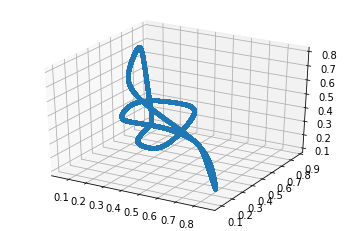

In [5]:
shift=19000
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(npa[shift:,1], npa[shift:,2], npa[shift:,3], '.')
plt.show()

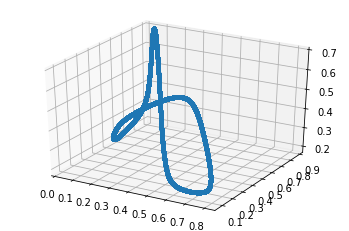

In [6]:
shift=19500
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(npa2[shift:,1], npa2[shift:,2], npa2[shift:,3], '.')
plt.show()

In [7]:
# time=500
# M = 6
# datas = np.zeros((M, 2*time*10+1, 2*N))
# for j in range(M):
#     inits = np.round(np.random.random(2*N),2)
#     print(j, inits)
#     inits_dict={}
#     for i,init in enumerate(inits[:int(N)]):
#         inits_dict['x'+str(i+1)]=init
#     for i,init in enumerate(inits[int(N):]):
#         inits_dict['y'+str(i+1)]=init
#     npa, vn = xpprun('wc_p.ode',inits=inits_dict, parameters={'total':time}, clean_after=True)
#     datas[j, :, :] = npa[:,1:].copy()

In [8]:
# colors = ['b', 'g', 'r', 'c', 'm', 'y']
# shift=8000
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for j in range(M):
#     ax.plot(datas[j,shift:,0], datas[j,shift:,3], datas[j,shift:,4], '.', c=colors[j], label=j)

# plt.legend()
# plt.show()

In [9]:
#put data in format for Combinatorial Dynamical System
hdata = np.array([npa[shift:,1:5], npa2[shift:,1:5]])
hdata = np.array([npa[shift:,1:], npa2[shift:,1:]])

hdata = np.reshape(hdata, (hdata.shape[0]*hdata.shape[1], hdata.shape[2]))
data_length_list = [npa.shape[0], npa2.shape[0]]
data_length_list = [npa[shift:,1:].shape[0], npa2[shift:,1:].shape[0]]

In [10]:
#Make combinatorial dynamical system from the data
delta=0.025
cds = cf.Combinatorial_Dynamical_System(delta)
cds.initialise_with_data(hdata, data_length_list)

In [11]:
#Get the recurrent components (Morse sets)
RCs = cds.get_recurrent_components()
len(RCs)

2

In [12]:
cubes = cds.cubes
print(len(cubes))

1134


<IPython.core.display.Javascript object>


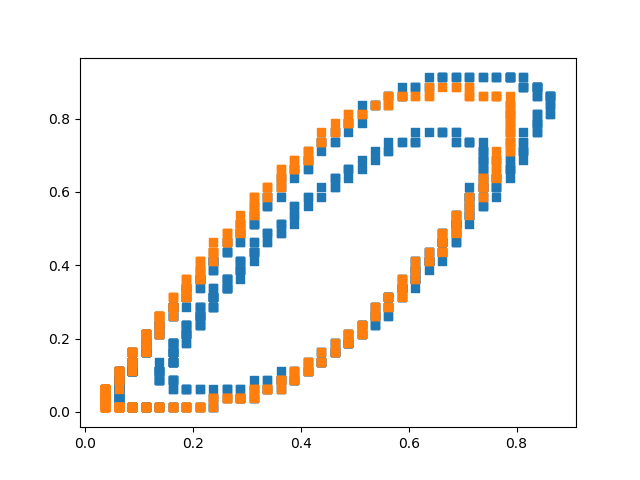

In [13]:
%matplotlib notebook

for i in range(len(RCs)):
    plt.scatter(np.array(cubes)[RCs[i]][:,0], np.array(cubes)[RCs[i]][:,3], marker='s')
plt.show()

In [14]:
Rcubes = {}
for i in range(len(RCs)):
    Rcubes[i] = cds.convert_indices_to_cubes(RCs[i])

In [17]:
RPcubes = {}

for i in range(len(RCs)):
    RPcubes[i] = []
    print("Component", i+1)
    RPcubes[i].append(cds.convert_indices_to_cubes(RCs[i]))
    
    # Betti numbers of recurrent components
#     print(cf.get_bettiNumbers_of_cubicalset(Rcubes[i], cds.delta))
    
    #Get (isolated) neighbourhood (candidate) around recurrent set
    N = RPcubes[i][0]
    N_ind = cds.convert_cubes_to_indices(N)
    S_ind = cds.invariantPart(N_ind)
    S_cubes = cds.convert_indices_to_cubes(S_ind)
    M = cds.cubical_wrap(S_cubes).intersection(cds.convert_indices_to_cubes(list(cds.G.nodes())))
    for mstep in range(10):
        M = cds.cubical_wrap(M).intersection(cds.convert_indices_to_cubes(list(cds.G.nodes())))
    
    #calculate index pair
    try:
        P1, P0, Pbar1, Pbar0 = cds.index_pair(M)
    
        P1cubes = cds.convert_indices_to_cubes(P1)
        P0cubes = cds.convert_indices_to_cubes(P0)
        RPcubes[i].append(P1cubes)
        RPcubes[i].append(P0cubes)
    
        #write index pairs to file for Conley index calcualtion with CHomP
        p1cubes = cds.convert_to_invertal_representation(P1cubes)
        filetxt= cf.convert_to_chomp_format(p1cubes, delta)
        with open('wc3_rc%s_p1.cub'%(i+1), 'w') as f:
            f.writelines(filetxt)

        if P0 != set():
            p0cubes = cds.convert_to_invertal_representation(P0cubes)
            filetxt= cf.convert_to_chomp_format(p0cubes, delta)
            with open('wc3_rc%s_p0.cub'%(i+1), 'w') as f:
                f.writelines(filetxt)
        else:
            0
#             print("P0 is empty")
        
        P1graph = nx.subgraph(cds.G, P1)
        cubefile, mapfile = cf.write_mapandcubes(P1graph, cds.delta, cds)
        with open('rc%s_P1_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)

        with open('rc%s_P1_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        P0graph = nx.subgraph(cds.G, P0)
        cubefile, mapfile = cf.write_mapandcubes(P0graph, cds.delta, cds)
        with open('rc%s_P0_map.map'%(i+1), 'w') as f:
            f.writelines(mapfile)
        with open('rc%s_P0_cubes.cub'%(i+1), 'w') as f:
            f.writelines(cubefile)
            
        proc = subprocess.Popen(['homcubes','rc%s_P1_cubes.cub'%(i+1), 'rc%s_P0_cubes.cub'%(i+1)],stdout=subprocess.PIPE)
        linenum = 0
        while True:
            line = proc.stdout.readline()
            if not line:
                break
            if line.rstrip().decode('UTF-8')[0:2] == 'H_':
                print("           "+line.rstrip().decode('UTF-8'))
            linenum+=1
            
    except Exception as e:
#         print("E")
        print(e)

Component 1
           H_0 = Z
           H_1 = Z
Component 2
           H_0 = Z
           H_1 = Z
